# Анализ результатов A/A/B-теста.

### Введение.

Цель: изучить целесообразность замены шрифтов в приложении. 

Задачи:

- исследовать воронку продаж;
- проанализировать результаты А/А/В-теста

В нашем распоряжении есть файл с результатами А/А/В-теста. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth

### Откроем файл c данными и изучим общую информацию о таблице. 

In [4]:
df = pd.read_csv('logs_exp.csv', sep='\t')

In [5]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Таблица состоит из 244 126 строк и 4 столбцов: 

- EventName (идентификатор события);
- DeviceIDHash (id устройства); 
- EventTimestamp (дата и время наступления события, записанные в формате timestamp); 
- ExpId (принадлежность к группе А/А/В-теста, где: 246 и 247 - группы А, т.е. контрольные, 248 - группа В, т.е. экспериментальная). 

Вывод: мы познакомились с таблицей, изучили общую информацию о данных; изменение форматов, в которых хранятся данные, не требуется. Преобразование данных в столбце 'EventTimestamp' в 'datetime' и 'date' выполним на следующем этапе работы. 

### Подготовка данных. 

Преобразуем данные в столбце 'EventTimestamp' в 'datetime', полученные значения запишем в отдельный столбец 'event_dt'. Из столбца 'event_dt' извлечем дату, запишем результат в столбец 'only_date'. 

In [5]:
df['event_dt'] = pd.to_datetime(df['EventTimestamp'], unit='s') # преобразуем данные в столбце 'EventTimestamp' (формат Timestamp) в формат datetime, полученные данные запишем в новый столбец 'event_dt'
df['only_date'] = pd.to_datetime(df['event_dt']).dt.date # извлечем из столбца 'event_dt' только дату, запишем в новый в столбец 'only_date'
df # выведем таблицу после преобразований на экран

,EventName,DeviceIDHash,EventTimestamp,ExpId,event_dt,only_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Удалим из таблицы столбец 'EventTimestamp'.

In [47]:
df = df.drop(columns = 'EventTimestamp') 

Переименуем названия столбцов в таблице. 

In [48]:
df.columns = ['event_name', 'user_id', 'group', 'date_time', 'date']

Проверим таблицу на наличие пропусков. 

In [49]:
df.isna().sum()

event_name    0
user_id       0
group         0
date_time     0
date          0
dtype: int64

Пропусков в таблице нет. 

Проверим таблицу на наличие явных дубликатов. 

In [50]:
df.duplicated().sum()

413

Наличие дубликатов говорит о том, что были случаи, когда один и тот же пользователь в одну секунду совершал несколько одинаковых действий (например, не получив подтверждения своего действия, сразу же повторял его). Удалим явные дубликаты из таблицы. 

In [51]:
print('Число строк в таблице до удаления явных дубликатов:', df.shape[0])

Число строк в таблице до удаления явных дубликатов: 244126


In [52]:
df = df.drop_duplicates()
print('Число строк в таблице после удаления явных дубликатов:', df.shape[0])

Число строк в таблице после удаления явных дубликатов: 243713


In [53]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Преобразуем записи значений в столбце 'event_name'. 

In [54]:
df = df.replace({'event_name' : { 'MainScreenAppear' : 'catalog', 'OffersScreenAppear' : 'offer', 'CartScreenAppear' : 'basket', 'PaymentScreenSuccessful' : 'payment', 'Tutorial' : 'tutorial'}})

Выведем на экран обработанную таблицу. 

In [55]:
df

,event_name,user_id,group,date_time,date
0,catalog,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,catalog,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,payment,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,basket,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,payment,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...
244121,catalog,4599628364049201812,247,2019-08-07 21:12:25,2019-08-07
244122,catalog,5849806612437486590,246,2019-08-07 21:13:59,2019-08-07
244123,catalog,5746969938801999050,246,2019-08-07 21:14:43,2019-08-07
244124,catalog,5746969938801999050,246,2019-08-07 21:14:58,2019-08-07


Вывод: мы преобразовали данные в столбце "EventTimestamp": получили столбцы date_time и date; переименовали столбцы таблицы, проверили ее на наличие пропусков, избавились от явных дубликатов в таблице; значения в столбце 'event_name' записали строчными буквами. 	

### Изучение и проверка данных. 

Посмотрим, сколько всего событий записаны в таблице.

In [56]:
print('Количество событий:', df['event_name'].shape[0])

Количество событий: 243713


Посмотрим, сколько всего пользователей в таблице. 

In [57]:
print('Количество пользователей:', df['user_id'].nunique())

Количество пользователей: 7551


In [58]:
count_mean = round(df['event_name'].shape[0] / df['user_id'].nunique())
print('Количество событий, которое, в среднем, приходится на одного пользователя:', count_mean)

Количество событий, которое, в среднем, приходится на одного пользователя: 32


#### Определим, данными за какой период мы располагаем. 

Найдем минимальную и максимальную даты в столбце 'date'. 

In [59]:
print('Начало периода:', df['date'].min())
print('Конец период', df['date'].max())

Начало периода: 2019-07-25
Конец период 2019-08-07


Построим гистограмму по дате.

Для этого сначала подготовим таблицу, по которой будем строить график. 

In [60]:
for_barplot = df['date'].value_counts()
df_for_barplot = for_barplot.to_frame().reset_index() 
df_for_barplot.columns = ['date', 'count']
df_for_barplot = df_for_barplot.sort_values(by='date', ascending=True)
df_for_barplot

,date,count
13,2019-07-25,9
12,2019-07-26,31
11,2019-07-27,55
10,2019-07-28,105
9,2019-07-29,184
8,2019-07-30,412
7,2019-07-31,2030
0,2019-08-01,36141
3,2019-08-02,35554
4,2019-08-03,33282


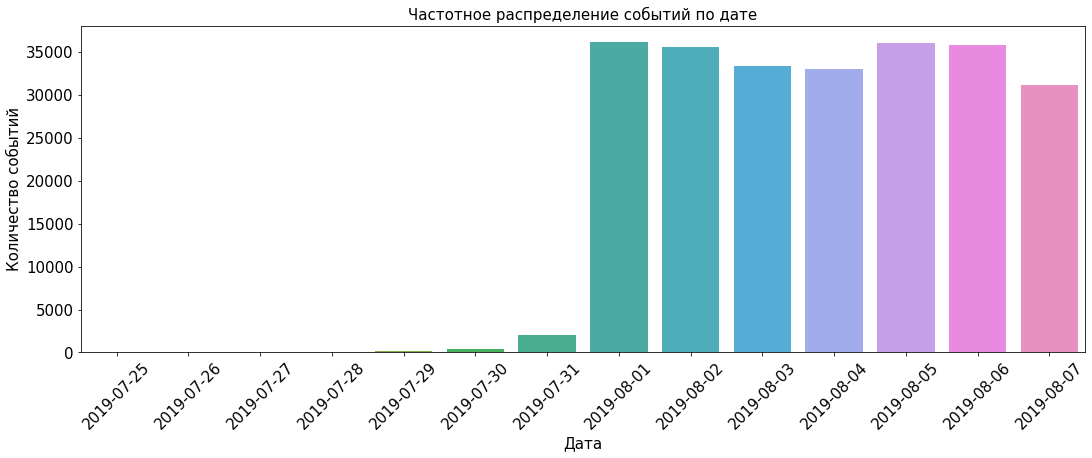

In [61]:
plt.figure(figsize=(18, 6))
sns.barplot(x="date", y="count", data=df_for_barplot, ci=None)
plt.title('Частотное распределение событий по дате', fontsize=15)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.xticks(np.arange(0, len(df_for_barplot['date']), 1), rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Мы располагаем полными данными за период с 1 по 7 августа. 

Оставим в таблице только события, произошедшие после 31.07.

In [62]:
print('Количество событий до удаления старых данных:', df.shape[0])

Количество событий до удаления старых данных: 243713


Отфильтруем данные в таблице, предварительно преобразовав формат данных в столбце 'date' - приведем данные к формату 'datetime64'.

In [63]:
df['date'] = df['date'].astype('datetime64')

df_new = df[df['date'] > '2019-07-31'] 

In [64]:
print('Количество событий после удаления старых данных:', df_new.shape[0])
print('Количество пользователей после удаления старых данных:', df_new['user_id'].nunique())

Количество событий после удаления старых данных: 240887
Количество пользователей после удаления старых данных: 7534


Посчитаем количество и долю событий (в %), которые мы потеряли, удалив старые данные. 

In [65]:
df_lost_count = df.shape[0] - df_new.shape[0]
print('Количество потерянных событий:', df_lost_count)

df_lost_share = round(df_lost_count/df.shape[0], 3)
print('Доля потерянных событий:', f'{df_lost_share:.1%}')

Количество потерянных событий: 2826
Доля потерянных событий: 1.2%


In [66]:
df_lost_count_user = df['user_id'].nunique() - df_new['user_id'].nunique()
print('Количество потерянных пользователей:', df_lost_count_user)

df_lost_share_user = round(df_lost_count_user/df['user_id'].nunique(), 3)
print('Доля потерянных пользователей:', f'{df_lost_share_user:.1%}')

Количество потерянных пользователей: 17
Доля потерянных пользователей: 0.2%


Убедимся, что в таблице остались пользователи из всех трех групп.

In [67]:
df_new['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

### Изучение воронки событий. 

Посмотрим, какие события есть таблице, и как часто они встречаются. Выведем события на экран в порядке убывания частоты, с которой они встречаются. 

In [68]:
df_new_event_name = df_new['event_name'].value_counts()

df_new_event_name = df_new_event_name.to_frame().reset_index() 
df_new_event_name.columns = ['event_name', 'count']
df_new_event_name = df_new_event_name.sort_values(by='count', ascending=False)
df_new_event_name

,event_name,count
0,catalog,117328
1,offer,46333
2,basket,42303
3,payment,33918
4,tutorial,1005


Посчитаем, сколько уникальных пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

In [69]:
event_name_count_users = df_new.pivot_table(index=['event_name'], values='user_id', aggfunc=['nunique'])
event_name_count_users = event_name_count_users.reset_index()

event_name_count_users.columns = ['event_name', 'users_count']


event_name_count_users = event_name_count_users.sort_values(by='users_count', ascending=False)

event_name_count_users

,event_name,users_count
1,catalog,7419
2,offer,4593
0,basket,3734
3,payment,3539
4,tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали каждое событие.

In [70]:
total_unique_users = df_new['user_id'].nunique()

event_name_count_users['share_of_total'] = round((event_name_count_users['users_count'] / total_unique_users), 3)

event_name_count_users

,event_name,users_count,share_of_total
1,catalog,7419,0.985
2,offer,4593,0.610
0,basket,3734,0.496
3,payment,3539,0.470
4,tutorial,840,0.111


In [71]:
total_unique_users

7534

Мы видим, что общее количество уникальных пользователей равно 7534, а это больше, чем количество уникальных пользователей, выполнивших первое действие в воронке. Видимо, действие tutorial можно было совершить в любой момент, даже до первого действия в воронке. 

Поэтому создадим строку event_name_total, которая будет содержать данные об общем количестве уникальных пользователей в таблице, и добавим ее в таблицу event_name_count_users.

In [72]:
event_name_total = {'event_name':'total','users_count':total_unique_users,'share_of_total':1}
event_name_count_users = event_name_count_users.append(event_name_total, ignore_index=True)

event_name_count_users = event_name_count_users.sort_values(by='users_count', ascending=False)

event_name_count_users = event_name_count_users.reset_index()

event_name_count_users = event_name_count_users.drop(columns = ['index'])

event_name_count_users

,event_name,users_count,share_of_total
0,total,7534,1.000
1,catalog,7419,0.985
2,offer,4593,0.610
3,basket,3734,0.496
4,payment,3539,0.470
5,tutorial,840,0.111


Предположим, что события из столбца 'event_name' происходят в следующем порядке. 

1. total (общее количество уникальных (скачавших приложение) пользователей,
2. catalog	(пользователь увидел главный экран приложения),
3. offer	(пользователь увидел экран с предложением),
4. basket	(пользователь увидел страницу с информацией о способах оплаты),
5. payment (пользователь увидел страницу с подтверждением успешной оплаты).

Событие 'tutorial' - пользователь обратился к странице с обучающей информацией о приложении. Это событие не укладывается в последовательную цепочку, ведь обратиться к этой странице можно на любом из этапов взаимодействия с приложением. Событие 'tutorial' не будем рассматривать как часть воронки. 

In [73]:
event_name_count_users = event_name_count_users[event_name_count_users['event_name'] != 'tutorial']
event_name_count_users

,event_name,users_count,share_of_total
0,total,7534,1.000
1,catalog,7419,0.985
2,offer,4593,0.610
3,basket,3734,0.496
4,payment,3539,0.470


Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем): так рассчитаем конверсию в шаг.

In [74]:
stage_0 = event_name_count_users.loc[0, 'users_count'] / event_name_count_users.loc[0, 'users_count']
stage_1 = event_name_count_users.loc[1, 'users_count'] / event_name_count_users.loc[0, 'users_count']
stage_2 = event_name_count_users.loc[2, 'users_count'] / event_name_count_users.loc[1, 'users_count']
stage_3 = event_name_count_users.loc[3, 'users_count'] / event_name_count_users.loc[2, 'users_count']
stage_4 = event_name_count_users.loc[4, 'users_count'] / event_name_count_users.loc[3, 'users_count']

stages = [stage_0, round((stage_1),3), round((stage_2),3), round((stage_3),3), round((stage_4),3)]
names = [event_name_count_users.loc[0, 'event_name'], event_name_count_users.loc[1, 'event_name'], event_name_count_users.loc[2, 'event_name'], event_name_count_users.loc[3, 'event_name'], event_name_count_users.loc[4, 'event_name']]

data = {'event_name': names, 'share_of_prev': stages}
df_data = pd.DataFrame(data) 
df_data

,event_name,share_of_prev
0,total,1.000
1,catalog,0.985
2,offer,0.619
3,basket,0.813
4,payment,0.948


Объединим таблицы event_name_count_users и df_data.

In [75]:
event_name_count_users = event_name_count_users.merge(df_data, on=['event_name'], how='inner')
event_name_count_users

,event_name,users_count,share_of_total,share_of_prev
0,total,7534,1.000,1.000
1,catalog,7419,0.985,0.985
2,offer,4593,0.610,0.619
3,basket,3734,0.496,0.813
4,payment,3539,0.470,0.948


In [76]:
loss = event_name_count_users.loc[1, 'share_of_prev'] - event_name_count_users.loc[2, 'share_of_prev']
loss

0.366

In [77]:
print('Наибольшее количество пользователей теряется на 2-м шаге:', f'{loss:.1%}', 'от числа тех, кто совершил событие "catalog", не совершил событие "offer".') 

Наибольшее количество пользователей теряется на 2-м шаге: 36.6% от числа тех, кто совершил событие "catalog", не совершил событие "offer".


Посчитаем, какая доля пользователей доходит от события "catalog" до "basket" (т.е. начинают оплачивать). 

In [78]:
stage_1_3 = round((event_name_count_users.loc[3, 'users_count'] / event_name_count_users.loc[1, 'users_count']), 2)
print('Доля пользователей, которая доходит от первого события до начала оплаты:', stage_1_3)

Доля пользователей, которая доходит от первого события до начала оплаты: 0.5


### Изучим результаты эксперимента. 

Проверим, нет ли в таблице пользователей, которые попали более чем в одну группу. 

In [80]:
bad_clients = df_new.groupby('user_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['user_id'] # выделили клиентов, попавших более чем в одну группу
print('Количество пользователей, которые попали более чем в одну группу:', bad_clients.shape[0])
#df_new = df_new.query('user_id not in @bad_clients')

Количество пользователей, которые попали более чем в одну группу: 0


Определим, сколько пользователей в каждой группе эксперимента. 

In [38]:
groups_count_users = df_new.groupby('group')['user_id'].nunique()
groups_count_users

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

В контрольных группах (А и А, или 246 и 247) 2484 и 2513 уникальных пользователей соответственно, а в экспериментальной группе (В) - 2537 пользователей. 

#### Проверим, есть ли разница между двумя контрольными группами (проанализируем результаты А/А-теста). 

Для этого выполним ряд предварительных действий, чтобы привести данные в удобный для анализа вид.  

Создадим сводную таблицу, состоящую из трех столбцов: событие ('event_name'), принадлежность к группе ('group'), количество пользователей ('users_count'). 

In [39]:
event_name_count_users_AAB = df_new.pivot_table(index=['event_name', 'group'], values='user_id', aggfunc=['nunique'])
event_name_count_users_AAB = event_name_count_users_AAB.reset_index()

event_name_count_users_AAB.columns = ['event_name', 'group', 'users_count']


event_name_count_users_AAB = event_name_count_users_AAB.sort_values(by='users_count', ascending=False)

event_name_count_users_AAB = event_name_count_users_AAB[event_name_count_users_AAB['event_name'] != 'tutorial']

event_name_count_users_AAB

,event_name,group,users_count
5,catalog,248,2493
4,catalog,247,2476
3,catalog,246,2450
6,offer,246,1542
8,offer,248,1531
7,offer,247,1520
0,basket,246,1266
1,basket,247,1238
2,basket,248,1230
9,payment,246,1200


Получим три отдельные таблицы в зависимости от принадлежности к группе (246, 247 или 248). 

In [40]:
event_name_count_users_AAB_246 = event_name_count_users_AAB[event_name_count_users_AAB['group'] == 246]
event_name_count_users_AAB_247 = event_name_count_users_AAB[event_name_count_users_AAB['group'] == 247]
event_name_count_users_AAB_248 = event_name_count_users_AAB[event_name_count_users_AAB['group'] == 248]

Объединим три полученные группы по столбцу 'event_name'. Выведем полученную таблицу на экран. 

In [41]:
event_name_count_users_AAB = event_name_count_users_AAB_246.merge(event_name_count_users_AAB_247, on=['event_name'], how='inner')
event_name_count_users_AAB = event_name_count_users_AAB.merge(event_name_count_users_AAB_248, on=['event_name'], how='inner')
event_name_count_users_AAB

,event_name,group_x,users_count_x,group_y,users_count_y,group,users_count
0,catalog,246,2450,247,2476,248,2493
1,offer,246,1542,247,1520,248,1531
2,basket,246,1266,247,1238,248,1230
3,payment,246,1200,247,1158,248,1181


Удалим ненужные для анализа столбцы, оставшиеся переименуем. Таким образом мы получим таблицу, удобную для дальнейшей работы. Выведем ее на экран. 

In [42]:
event_name_count_users_AAB = event_name_count_users_AAB.drop(columns = ['group_x', 'group_y', 'group'])
event_name_count_users_AAB.columns = ['event_name', 'users_count_246', 'users_count_247', 'users_count_248']
event_name_count_users_AAB

,event_name,users_count_246,users_count_247,users_count_248
0,catalog,2450,2476,2493
1,offer,1542,1520,1531
2,basket,1266,1238,1230
3,payment,1200,1158,1181


А также сформируем и добавим в таблицу строку, которая будет содержать данные об общем количестве уникальных пользователей в каждой группе. 

In [43]:
df_groups_count_users = groups_count_users.to_frame().reset_index() 
df_groups_count_users.columns = ['group', 'count']
df_groups_count_users

,group,count
0,246,2484
1,247,2513
2,248,2537


In [44]:
users_groups_total = {'event_name':'total','users_count_246': df_groups_count_users.loc[0, 'count'],'users_count_247':df_groups_count_users.loc[1, 'count'], 'users_count_248':df_groups_count_users.loc[2, 'count']}
event_name_count_users_AAB = event_name_count_users_AAB.append(users_groups_total, ignore_index=True)

event_name_count_users_AAB = event_name_count_users_AAB.sort_values(by='users_count_246', ascending=False)

event_name_count_users_AAB = event_name_count_users_AAB.reset_index()

event_name_count_users_AAB = event_name_count_users_AAB.drop(columns = ['index'])

event_name_count_users_AAB

,event_name,users_count_246,users_count_247,users_count_248
0,total,2484,2513,2537
1,catalog,2450,2476,2493
2,offer,1542,1520,1531
3,basket,1266,1238,1230
4,payment,1200,1158,1181


#### Напишем функцию для проверки гипотезы о равенстве долей. 

In [45]:
def differences (base_stage, next_stage):
# пропорция успехов в первой группе:
    p1 = next_stage[0]/base_stage[0]

# пропорция успехов во второй группе:
    p2 = next_stage[1]/base_stage[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (next_stage[0] + next_stage[1]) / (base_stage[0] + base_stage[1])

# разница пропорций в датасетах
    difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/base_stage[0] + 1/base_stage[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / base_stage[0] + 1 / base_stage[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value) 
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

#### Проверим гипотезы о равенстве долей пользователей на каждом из этапов воронки для двух контрольных групп (246 и 247, т.е. А/А-тест).

Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие catalog, в группах 246 и 247 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие catalog, в группах 246 и 247 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

Применим функцию для проверки гипотезы о равенстве долей пользователей, выполнивших событие catalog, в группах 246 и 247. 

In [46]:
alpha = .01 # критический уровень статистической значимости
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_247']])
next_stage = np.array(event_name_count_users_AAB.loc[1, ['users_count_246', 'users_count_247']])

differences (base_stage, next_stage)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие offer, в группах 246 и 247 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие offer, в группах 246 и 247 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

Применим функцию для проверки гипотезы о равнестве долей пользователей, выполнивших событие offer, в группах 246 и 247. 

In [47]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_247']])
next_stage = np.array(event_name_count_users_AAB.loc[2, ['users_count_246', 'users_count_247']])
differences (base_stage, next_stage)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие basket, в группах 246 и 247 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие basket, в группах 246 и 247 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

Применим функцию для проверки гипотезы о равнестве долей пользователей, выполнивших событие basket, в группах 246 и 247. 

In [48]:
alpha = .05 # критический уровень статистической значимости
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_247']])
next_stage = np.array(event_name_count_users_AAB.loc[3, ['users_count_246', 'users_count_247']])

differences (base_stage, next_stage)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие payment, в группах 246 и 247 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие payment, в группах 246 и 247 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

Применим функцию для проверки гипотезы о равнестве долей пользователей, выполнивших событие payment, в группах 246 и 247. 

In [49]:
alpha = .05 # критический уровень статистической значимости
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_247']])
next_stage = np.array(event_name_count_users_AAB.loc[4, ['users_count_246', 'users_count_247']])

differences (base_stage, next_stage)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<b>Вывод:</b> поскольку на всех этапах воронки значимых различий в долях между группами 246 и 247, принявшими участие в А/А-тесте, не выявлено, постольку можно говорить о том, что разбиение на группы работает корректно. 

Теперь сравним результаты в группе 248 (экспериментальная группа В) с каждой из контрольных групп в отдельности (246 и 247) по каждому событию. 

#### Сравнение результатов в группах 246 и 248. 

Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие catalog, в группах 246 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие catalog, в группах 246 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [50]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[1, ['users_count_246', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие offer, в группах 246 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие offer, в группах 246 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [51]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[2, ['users_count_246', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие basket, в группах 246 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие basket, в группах 246 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [52]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[3, ['users_count_246', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие payment, в группах 246 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие payment, в группах 246 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [53]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[4, ['users_count_246', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<b>Вывод:</b> ни по одному из событий не выявлены значимые различия между группами 246 и 248. 

#### Сравнение результатов в группах 247 и 248. 

Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие catalog, в группах 247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие catalog, в группах 247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [54]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[1, ['users_count_247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие catalog, в группах 247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие catalog, в группах 247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [55]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[2, ['users_count_247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие offer, в группах 247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие offer, в группах 247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [56]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[3, ['users_count_247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие payment, в группах 247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие payment, в группах 247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [57]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[4, ['users_count_247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Рассчитаем значения долей для наступления события paymentscreensuccessful в группах 247 и 248.

In [58]:
paymentscreensuccessful_share_247 = event_name_count_users_AAB.loc[3, 'users_count_247'] / event_name_count_users_AAB.loc[2, 'users_count_247']
paymentscreensuccessful_share_248 = event_name_count_users_AAB.loc[3, 'users_count_248'] / event_name_count_users_AAB.loc[2, 'users_count_248']
print('Доля пользователей, совершивших событие paymentscreensuccessful, в группе 247:', round(paymentscreensuccessful_share_247, 2))
print('Доля пользователей, совершивших событие paymentscreensuccessful, в группе 248:', round(paymentscreensuccessful_share_248, 2))

Доля пользователей, совершивших событие paymentscreensuccessful, в группе 247: 0.81
Доля пользователей, совершивших событие paymentscreensuccessful, в группе 248: 0.8


<b>Вывод:</b> не выявлены значимые различия между группами 247 и 248.

#### Сравнение результатов в группах 246+247 и 248. 

In [59]:
event_name_count_users_AAB['users_count_246+247'] = event_name_count_users_AAB['users_count_246'] + event_name_count_users_AAB['users_count_247']
event_name_count_users_AAB

,event_name,users_count_246,users_count_247,users_count_248,users_count_246+247
0,total,2484,2513,2537,4997
1,catalog,2450,2476,2493,4926
2,offer,1542,1520,1531,3062
3,basket,1266,1238,1230,2504
4,payment,1200,1158,1181,2358


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие catalog, в группах 246+247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие catalog, в группах 246+247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01.

In [60]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246+247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[1, ['users_count_246+247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие offer, в группах 246+247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие offer, в группах 246+247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [61]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246+247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[2, ['users_count_246+247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие basket, в группах 246+247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие basket, в группах 246+247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [62]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246+247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[3, ['users_count_246+247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем нулевую и альтернативную гипотезы. 

Нулевая гипотеза: доли пользователей, выполнивших событие payment, в группах 246+247 и 248 не различаются. 

Альтернативная гипотеза: доли пользователей, выполнивших событие payment, в группах 246+247 и 248 различаются. 

Проверять гипотезу будем на уровне значимости 0,01. 

In [63]:
base_stage = np.array(event_name_count_users_AAB.loc[0, ['users_count_246+247', 'users_count_248']])
next_stage = np.array(event_name_count_users_AAB.loc[4, ['users_count_246+247', 'users_count_248']])

differences (base_stage, next_stage)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<b>Вывод:</b> не выявлены значимые различия между группами 246+247 (общая контрольная группа) и 248 (экспериментальная группа). 

<b>Общий вывод по проекту:</b> изменение шрифтов в приложении не приводит к изменению продаж. Следовательно, шрифты можно менять, а можно не менять - это не повлияет на продажи. 